In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm

In [ ]:
data = pd.read_csv("poly_regression_large.csv")
data_shuffled = data.sample(frac=1, random_state=42)  #Shuffle the data
X = data_shuffled["x"]
Y = data_shuffled["y"]
print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")

X shape: (1000,)
Y shape: (1000,)


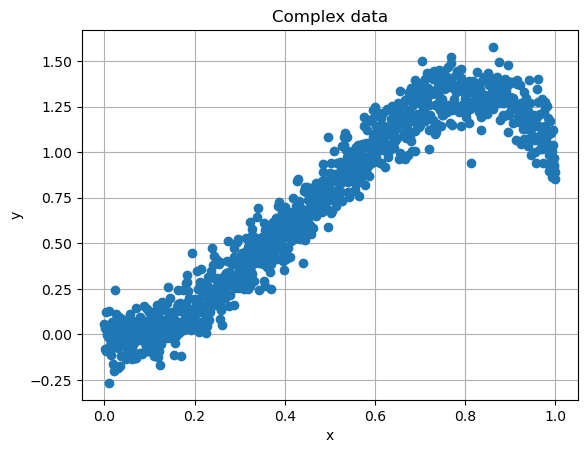

In [13]:
# Visualize the data
plt.plot(X, Y, 'o')
plt.title("Complex data")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.show()

In [14]:
train_size = int(0.8 * len(X))
Xtrain = X[:train_size]
Xtest = X[train_size:]
Ytrain = Y[:train_size]
Ytest = Y[train_size:]

#Because of the index problem in the SGD function
#It resets the index without conserving it as column
Xtrain = Xtrain.reset_index(drop=True)
Xtest = Xtest.reset_index(drop=True)
Ytrain = Ytrain.reset_index(drop=True)
Ytest = Ytest.reset_index(drop=True)

Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape


((800,), (200,), (800,), (200,))

In [15]:
def SGD(loss, grad_loss, X, Y, theta0, alpha, batch_size, n_epochs):
    N = X.shape[0] # We assume both X and Y has shape (N, )
    d = theta0.shape[0] # While theta0 has shape (d, )
    idx = np.arange(0, N) # This is required for the shuffling
    
    # Initialization of history vectors
    theta_history = np.zeros((n_epochs, d))  # Save parameters at each epoch 
    loss_history = np.zeros((n_epochs, ))  # Save loss values at each epoch
    grad_norm_history = np.zeros((n_epochs, ))  # Save gradient norms at each epoch
    
    # Initialize weights
    theta = theta0
    for epoch in range(n_epochs):
        # Shuffle the data at the beginning of each epoch
        np.random.shuffle(idx)
        X = X[idx]
        y = Y[idx]

        # Initialize a vector that saves the gradient of the loss at each iteration
        grad_loss_vec = []

        for batch_start in range(0, N, batch_size):
            batch_end = min(batch_start + batch_size, N)
            X_batch = X[batch_start:batch_end]
            y_batch = y[batch_start:batch_end]
            
            # Compute the gradient of the loss
            gradient = grad_loss(theta, X_batch, y_batch)
            grad_loss_vec.append(np.linalg.norm(gradient, 2))

            # Update weights
            theta = theta - alpha * gradient

        # Save the updated values
        theta_history[epoch] = theta
        loss_history[epoch] = loss(theta, X, y)
        grad_norm_history[epoch] = np.mean(grad_loss_vec)
    
    return theta_history, loss_history, grad_norm_history

In [16]:
def f(x,theta):
    y = 0
    for j in range(len(theta)):
        y = y + theta[j] * x**j
    return y

def loss(theta, X, y):#MSE
    y_pred = f(X,theta)
    error = np.square(y_pred - y)
    return np.mean(error)

def vandermonde(x,K):
    N = x.shape[0]
    PhiX = np.zeros((N,K))
    for j in range(K):
        PhiX[:, j]= x**j
    return PhiX

def grad_loss(theta, X, y):
    N = len(y) 
    K = len(theta) 
    PhiX = vandermonde(X, K)
    y_pred = PhiX @ theta # (NxK) x (Kx1) = Nx1
    error = y_pred - y  
    grad = (2 * (PhiX.T @ error)) / N 
    return grad


In [18]:
theta0 = np.zeros((5,))
result_SGD = SGD(loss, grad_loss, Xtrain, Ytrain, theta0, 0.25, 20, 1000)
computed_theta_SGD = result_SGD[0][-1]
print(f"Computed theta with SGD: {computed_theta_SGD}")

Computed theta with SGD: [-0.03690009  0.24903501  3.3795863   0.54467603 -3.16994438]


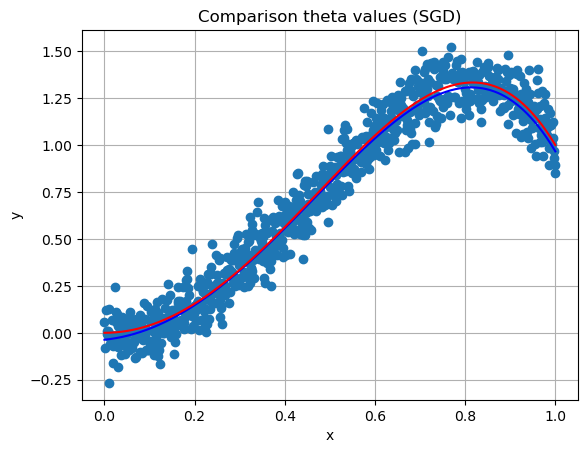

In [ ]:
######### SGD

theta_true = [0,0,4,0,-3]
plt.plot(Xtrain, Ytrain, 'o')
plt.plot(Xtrain.sort_values(), f(Xtrain.sort_values(), computed_theta_SGD), 'b')
plt.plot(Xtrain.sort_values(), f(Xtrain.sort_values(),theta_true), 'r')
plt.title("Comparison theta values (SGD)")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.show()

In [20]:
def GD(grad_loss, X, y,  theta0, alpha, kmax = 100, tolf= 1e-6, tolx= 1e-6, backtrack = False):
    grad_norm = np.zeros((kmax+1, ))
    grad_norm[0] = np.linalg.norm(grad_loss(theta0, X, y))
    
       
    alphavalues = []
    for k in range(kmax):
        
        theta = theta0 - alpha * grad_loss(theta0,X,y)
        
        grad_norm[k+1] = np.linalg.norm(grad_loss(theta, X, y))
        
        if np.linalg.norm(grad_loss(theta, X, y)) <= tolf * grad_norm[0]:
            print(f"Break because of tolf, at the {k} iteration")
            break
        elif np.linalg.norm(grad_loss(theta, X, y))<= tolx:
            print("Break because of tolx")
            break
        
        
        theta0 = theta
    #cut off the exceeding values
    grad_norm = grad_norm[:k+1]
    
    return theta, k, grad_norm, alphavalues

In [ ]:
######### GD

theta0 = np.zeros((5,))
theta_true = [0,0,4,0,-3]
result_GD = GD(grad_loss, Xtrain, Ytrain,  theta0, 0.6, 13000, 1e-6, 1e-6, False)
computed_theta_GD = result_GD[0]
print(f"Computed theta with GD: {computed_theta_GD}")

Computed theta with GD: [-0.03284457  0.27028636  3.36448079  0.55870435 -3.15455517]


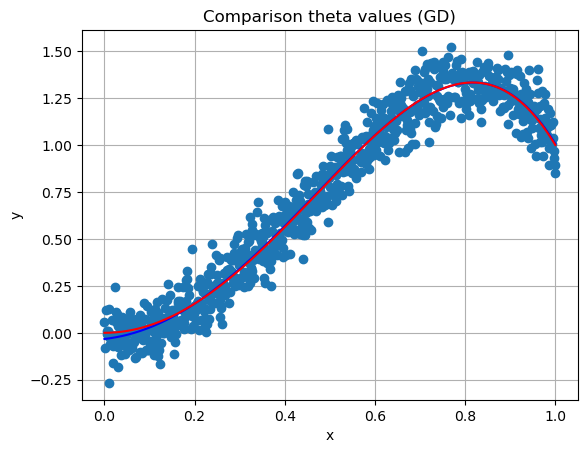

In [22]:
theta_true = [0,0,4,0,-3]
plt.plot(Xtrain, Ytrain, 'o')
plt.plot(Xtrain.sort_values(), f(Xtrain.sort_values(), computed_theta_GD), 'b')
plt.plot(Xtrain.sort_values(), f(Xtrain.sort_values(),theta_true), 'r')
plt.title("Comparison theta values (GD)")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.show()

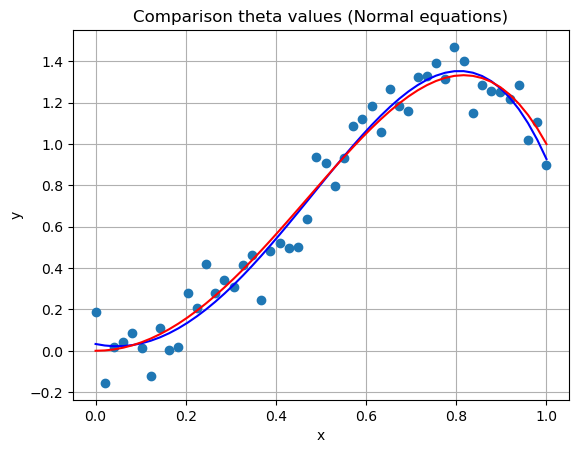

In [23]:
#Regression using small dataset
small_data = pd.read_csv('poly_regression_small.csv')
X_small = small_data['x']
Y_small = small_data['y']

def vandermonde_NE(x,K):
    N = x.shape[0]
    PhiX = np.zeros((K,N))
    for j in range(K):
        PhiX[j, :]= x**j
    return PhiX

theta_true = [0,0,4,0,-3]
PhiX =  vandermonde_NE(X_small,K = 5)
L = np.linalg.cholesky(PhiX@PhiX.T)

z = np.linalg.solve(L, PhiX@Y_small)

result_NorEq = np.linalg.solve(L.T, z)

plt.plot(X_small, Y_small, 'o')
plt.plot(X_small, f(X_small, result_NorEq), 'b')
plt.plot(X_small, f(X_small,theta_true), 'r')
plt.title("Comparison theta values (Normal equations)")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.show()

Polynomial of degree: 3
Computed theta with Normal Equations: [-0.2568291   2.77151694 -1.20508764]
Test set error with k = 3 is 0.021707725805247505
 
Polynomial of degree: 3
Computed theta with SGD: [-0.26811173  2.83313349 -1.26086896]
Test set error with k = 3 is 0.021686225227623132
 
Break because of tolf, at the 2783 iteration
Polynomial of degree: 3
Computed theta with GD: [-0.28093055  2.84595064 -1.23871527]
Test set error with k = 3 is 0.021430337791126047
 
Polynomial of degree: 4
Computed theta with Normal Equations: [ 0.07903542 -1.47472763  9.51845896 -7.14903107]
Test set error with k = 4 is 0.011201927462983265
 
Polynomial of degree: 4
Computed theta with SGD: [-0.01543001 -0.21670911  6.46330648 -5.11640587]
Test set error with k = 4 is 0.010968705535338961
 
Polynomial of degree: 4
Computed theta with GD: [-4.47149246e-02  5.78396728e-03  5.89227338e+00 -4.76143357e+00]
Test set error with k = 4 is 0.01055609649187183
 
Polynomial of degree: 5
Computed theta with No

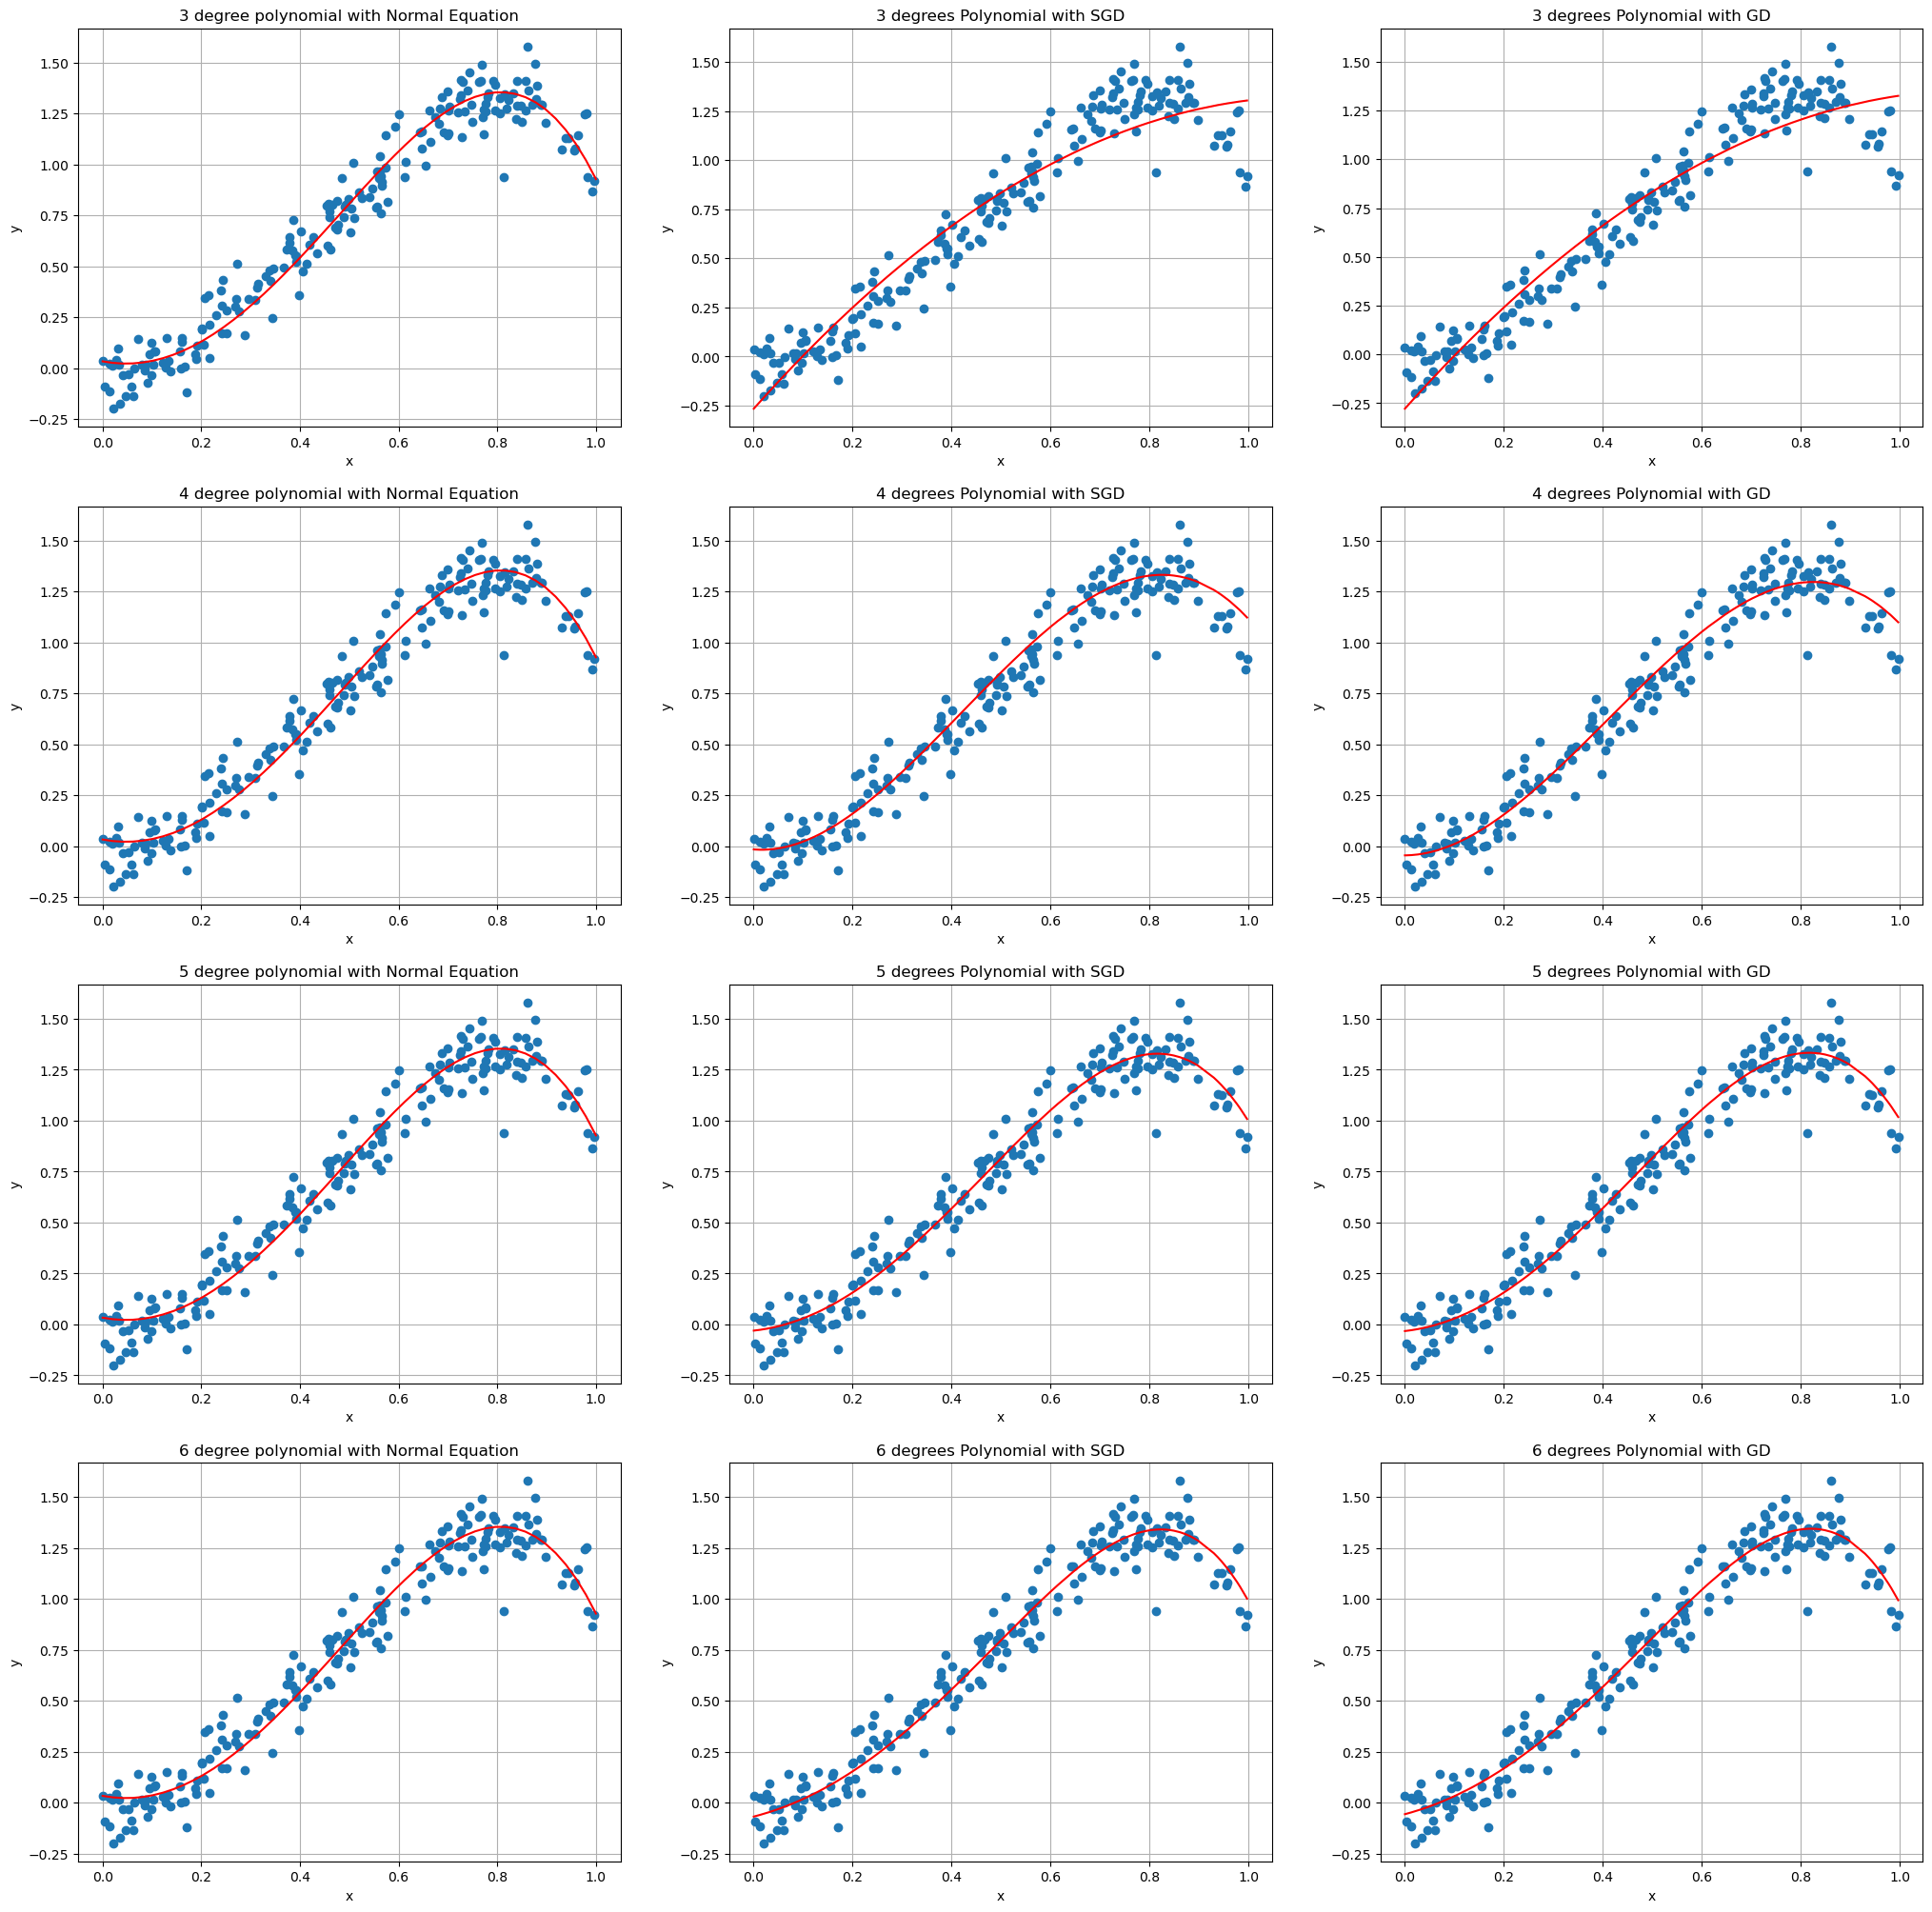

In [29]:
k_degrees = [3,4,5,6]
plt.figure(figsize=(25,25))
theta_true = [0,0,4,0,-3]
i = 1
Ntest = len(Ytest)

for k in k_degrees:
    ############### Normal Equations
    PhiX =  vandermonde_NE(X_small,K = k)
    L = np.linalg.cholesky(PhiX@PhiX.T)
    z = np.linalg.solve(L, PhiX@Y_small)
    computed_theta_NorEq = np.linalg.solve(L.T, z)
    
    PhiX = vandermonde(Xtest, k)
    y_pred_NorEq = PhiX @ computed_theta_NorEq # (NxK) x (Kx1) = Nx1
    error_NorEq = np.sum((y_pred_NorEq - Ytest)**2)/Ntest
    
    print(f"Polynomial of degree: {k}")
    print(f"Computed theta with Normal Equations: {computed_theta_NorEq}")
    print(f"Test set error with k = {k} is {error_NorEq}")
    print(" ")
    
    plt.subplot(4,3,i)
    plt.plot(Xtest, Ytest, 'o')
    plt.plot(X_small, f(X_small, result_NorEq), 'r')
    plt.title(f"{k} degree polynomial with Normal Equation")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid()
    
    
    ############### SGD
    theta0 = np.zeros((k,))
    result_SGD = SGD(loss, grad_loss, Xtrain, Ytrain, theta0, 0.25, 20, 1000)
    computed_theta_SGD = result_SGD[0][-1]
    print(f"Polynomial of degree: {k}")
    print(f"Computed theta with SGD: {computed_theta_SGD}")
    plt.subplot(4,3,i+1)
    plt.plot(Xtest, Ytest, 'o')
    plt.plot(Xtest.sort_values(), f(Xtest.sort_values(), computed_theta_SGD), 'r')
    plt.title(f"{k} degrees Polynomial with SGD")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid()
    
    PhiX = vandermonde(Xtest, k)
    y_pred_SGD = PhiX @ computed_theta_SGD # (NxK) x (Kx1) = Nx1
    error_SGD = np.sum((y_pred_SGD - Ytest)**2)/Ntest
    print(f"Test set error with k = {k} is {error_SGD}")
    
     
    print(" ")
    
    ############### GD
    result_GD = GD(grad_loss, Xtrain, Ytrain,  theta0, 0.6, kmax = 13000, tolf= 1e-6, tolx= 1e-6, backtrack = False)
    computed_theta_GD = result_GD[0]
    print(f"Polynomial of degree: {k}")
    print(f"Computed theta with GD: {computed_theta_GD}")
    plt.subplot(4,3,i+2)
    plt.plot(Xtest, Ytest, 'o')
    plt.plot(Xtest.sort_values(), f(Xtest.sort_values(), computed_theta_GD), 'r')
    plt.title(f"{k} degrees Polynomial with GD")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid()

    i += 3
    
    y_pred_GD = PhiX @ computed_theta_GD # (NxK) x (Kx1) = Nx1
    error_GD = np.sum((y_pred_GD - Ytest)**2)/Ntest
    print(f"Test set error with k = {k} is {error_GD}")
    print(" ")

plt.show()

### We can notice how in the case of the degree 3 polynomial, the normal equations are already able to approximate the regression function fairly well, while SGD and GD still significantly underfit the model.

### Apart from this, all three models behave almost the same, with a test set error that decreases as k increases.
### The values ​​of the theta in the case of k = 5 are very similar to the true values ​​in all three cases. In the case of the normal equation they are slightly overestimated, in fact among the three models it is the one with the largest error.

### In the end it is clear that in these cases, using such little complex functions and matrices, the most efficient method is to use the Normal Equation, as it has the best trade-off between time complexity and results obtained.